# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the samples on our demo page via [this](https://grad-tts.github.io/) link.

You can access Google Colab demo notebook via [this](https://colab.research.google.com/drive/1YNrXtkJQKcYDmIYJeyX8s5eXxB4zgpZI?usp=sharing) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

<sup>\*Equal contribution.</sup>

**Note**: for fast synthesis prefer running inference on GPU device.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS, GradTTS2
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN
import epitran
from text.bn_phonemiser import bangla_text_normalize, replace_number_with_text

In [3]:
N_SPKS = 1  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)

In [22]:
# generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
#                     params.n_enc_channels, params.filter_channels,
#                     params.filter_channels_dp, params.n_heads, params.n_enc_layers,
#                     params.enc_kernel, params.enc_dropout, params.window_size,
#                     params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
#                     pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
# generator.load_state_dict(torch.load('/mnt/Work/Thesis/Bangla_TTS/scratch_implementations/Grad-TTS/logs/new_exp/grad_39.pt', map_location=lambda loc, storage: loc))

generator = GradTTS2(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(torch.load('/mnt/Work/Thesis/Bangla_TTS/scratch_implementations/Grad-TTS/logs/new_exp_sdp/grad_77.pt', map_location=lambda loc, storage: loc))

_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./resources/cmu_dictionary')

Number of parameters: 16225928


In [23]:
HIFIGAN_CONFIG = './checkpts/hifigan-config.json'
HIFIGAN_CHECKPT = './checkpts/hifigan.pt'


ipa_dict = {'ɖ̤': 0,
                'kʰ': 1,
                'n': 2,
                'm': 3,
                'ɡ̤': 4,
                'ʃ': 5,
                'b̤': 6,
                'd̪̤': 7,
                'ŋ': 8,
                'pʰ': 9,
                'ɽ̤': 10,
                'k': 11,
                'a': 12,
                'b': 13,
                'r': 14,
                'ʈʰ': 15,
                'V': 16,
                'ɖ': 17,
                't̪ʰ': 18,
                'p': 19,
                'z': 20,
                'e': 21,
                't̪': 22,
                'u': 23,
                'j': 24,
                'd̪': 25,
                'o': 26,
                'i': 27,
                'd͡z': 28,
                's': 29,
                'd͡z̤': 30,
                'ঃ': 31,
                'h': 32,
                '্': 33,
                'ɽ': 34,
                '̃': 35,
                'l': 36,
                'ʈ': 37,
                'ɡ': 38,
                'ɔ': 39,
                ' ': 40}


def get_ipa_tokens_from_text(tokens):
    ipa_tokens = []
    for tok in tokens:
        if tok in ipa_dict.keys():
            ipa_tokens.append(ipa_dict[tok])

    return ipa_tokens

def get_text(text, add_blank=True):
    bn_phonemizer = epitran.Epitran('ben-Beng-east')
    text_norm = replace_number_with_text(text)
    text_norm = bangla_text_normalize(text_norm)
    text_tokens = bn_phonemizer.trans_list(text_norm)
    ipa_tokens = get_ipa_tokens_from_text(text_tokens)
    # text_norm = torch.IntTensor(ipa_tokens)
    return ipa_tokens


In [24]:
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h).cuda()
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


In [25]:
text = "তাতে কোনো ঝামেলা নেই, সমস্যা হল রোজ দু'বেলা টিফিন- ক্যারিয়ারে খাবার নেওয়ার সময় ও বাড়ির সামনে কেউ দেখে না ফেলে।"

In [26]:
x = torch.LongTensor(get_text(text)).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 117]), tensor([117], device='cuda:0'))

Grad-TTS RTF: 0.23426195983886722


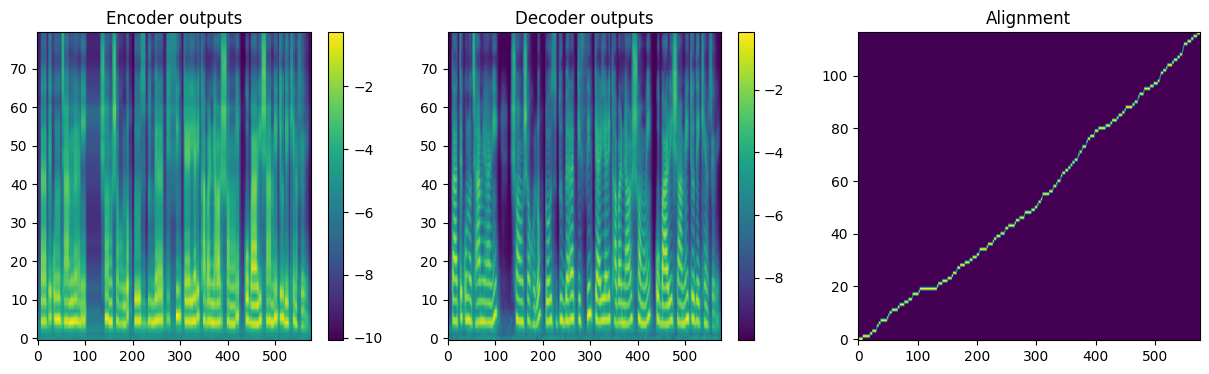

In [27]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

In [21]:
y_dec = y_dec.cuda()

with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

In [28]:
y_dec = y_dec.cuda()

with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

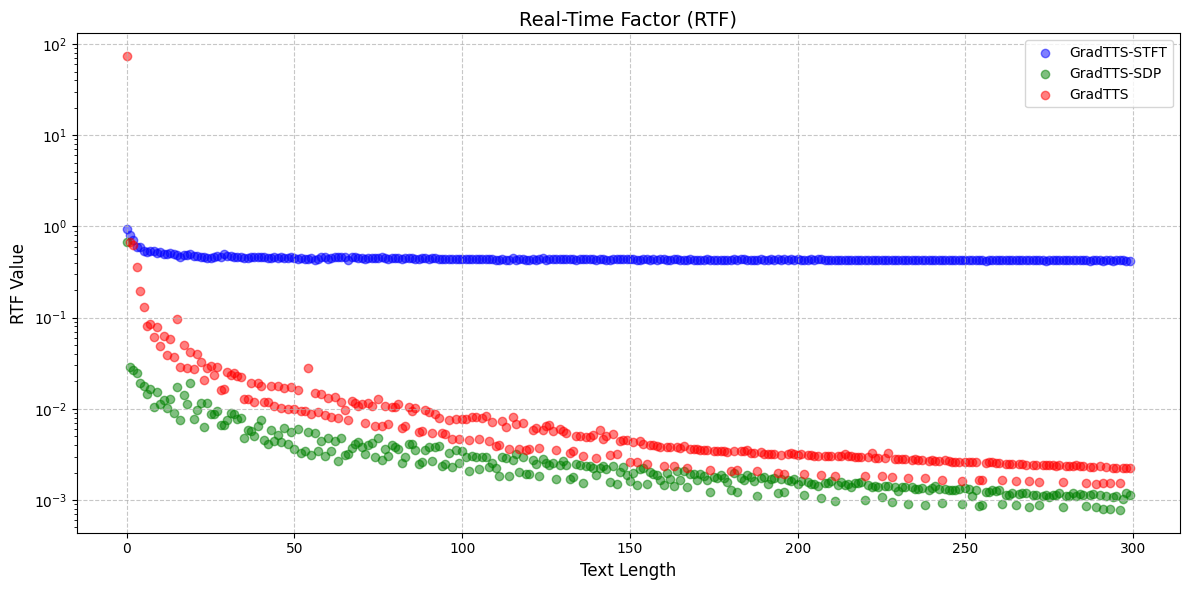

In [12]:
import matplotlib as plt

import matplotlib.pyplot as plt
import json

def read_file_as_list(filename):
    with open(filename, 'r') as file:
        content = file.read().strip()  # Read the file content and remove any extra whitespace
        # Remove the square brackets and split the content by commas
        content = content[1:-1].split(',')
        # Convert the strings to floats
        return [float(x) for x in content]

# Parse the string data into lists of floats
grad_tts = read_file_as_list("grad_tts_rtf.txt")[:300] 
sdf = read_file_as_list("grad_tts_sdp_rtf.txt")[:300]
stft = read_file_as_list("grad_tts_stft_rtf.txt")[:300]

# Create x-axis values (iteration numbers)
iterations = list(range(len(grad_tts)))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each RTF measurement
plt.scatter(iterations, stft, label='GradTTS-STFT', color='blue', alpha=0.5)
plt.scatter(iterations, sdf, label='GradTTS-SDP', color='green', alpha=0.5)
plt.scatter(iterations, grad_tts, label='GradTTS', color='red', alpha=0.5)

# Customize the plot
plt.title('Real-Time Factor (RTF)', fontsize=14)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('RTF Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Set y-axis to log scale since there's a large range of values
plt.yscale('log')
plt.savefig("rtf.pdf", format="pdf", bbox_inches="tight")

# Adjust layout to prevent label cutoff
plt.tight_layout()